In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'blackjack-hands:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1527500%2F2521370%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240506%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240506T235007Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D18b8326703ddbd9f5bb36127d8e0a8c5b4d8ffe164b891379194662863c84e2b385459a2a468db2a3466a669bd7ce7a394f6ef117d41c5a4ffe5db3791e8244f7ed12e687d9358a29124051d948908a135a652976465290f34b45dd41043863609a17047e8a3a2b9d8985f9f3d28eb9cf7a2dfa89c6653dde107193ed3e329ec53094c2dbf661ba48ef08c4a0c5dcf2c7c167c424dd7602959d33788fa6676db6e7611106b80a5b1b134dd09aec6ba5d0df85d76f8e5d13d36de92ce91b318eb693d7d000550ad3063aa17129e27e0deab035f527010bb9d6456008804ba45e5ce1937a59027c1869745e511b71572854b7ba1fa8c039d13c32b69eb2147b643'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 821113794 bytes downloaded
Downloaded and uncompressed: blackjack-hands
Data source import complete.


# Data Exploration

In [39]:
# !pip install plotly==5.11.0
import pandas as pd
import numpy as np
# import plotly_express as px
import ipywidgets as widgets
import ast
from math import nan
import warnings
warnings.filterwarnings('ignore')

We will use only 500k samples as 50M requires way too much computational resources.

In [40]:
data = pd.read_csv('../input/blackjack-hands/blackjack_simulator.csv', sep = ',' , nrows = 500_000)  # Because 5M is too much :)
data.head(10)

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 11]","[10, 4, 10]",24,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,10,"[5, 5]","[10, 8]",18,"[[5, 5, 11]]",[21],"[['H', 'S']]",-2,0,1.0
2,0,406,6,"[3, 10]","[6, 6, 10]",22,"[[3, 10]]",[13],[['S']],-2,0,1.0
3,0,401,10,"[5, 9]","[10, 8]",18,"[[5, 9, 11, 3]]",[18],"[['H', 'H', 'S']]",-1,0,0.0
4,0,395,8,"[6, 10]","[8, 2, 10]",20,"[[6, 10, 10]]",[26],[['H']],-1,0,-1.0
5,0,389,7,"[3, 4]","[7, 2, 10]",19,"[[3, 4, 11]]",[18],"[['H', 'S']]",-2,0,-1.0
6,0,383,6,"[3, 3]","[6, 10, 10]",26,"[[3, 2, 10], [3, 4, 5]]","[15, 12]","[['P', 'H', 'S'], ['H', 'S']]",-1,0,2.0
7,0,374,3,"[10, 8]","[3, 10, 7]",20,"[[10, 8]]",[18],[['S']],2,0,-1.0
8,0,369,5,"[8, 10]","[5, 10, 9]",24,"[[8, 10]]",[18],[['S']],1,0,1.0
9,0,364,9,"[6, 8]","[9, 2, 5, 11]",17,"[[6, 8, 6]]",[20],"[['H', 'S']]",0,0,1.0


**Reminder:** S = Stand , H = Hit , D = Double , P = Split , R = Surrender , I = Insurance , N = No Insurance

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shoe_id             500000 non-null  int64  
 1   cards_remaining     500000 non-null  int64  
 2   dealer_up           500000 non-null  int64  
 3   initial_hand        500000 non-null  object 
 4   dealer_final        500000 non-null  object 
 5   dealer_final_value  500000 non-null  object 
 6   player_final        500000 non-null  object 
 7   player_final_value  500000 non-null  object 
 8   actions_taken       500000 non-null  object 
 9   run_count           500000 non-null  int64  
 10  true_count          500000 non-null  int64  
 11  win                 500000 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 45.8+ MB


In [42]:
data['initial_hand'] = data['initial_hand'].apply(lambda x: ast.literal_eval(x))
data['dealer_final'] = data['dealer_final'].apply(lambda x: ast.literal_eval(x))
data['player_final'] = data['player_final'].apply(lambda x: ast.literal_eval(x))
data['player_final_value'] = data['player_final_value'].apply(lambda x: ast.literal_eval(x))
data['actions_taken'] = data['actions_taken'].apply(lambda x: ast.literal_eval(x))
# data = data[data['actions_taken'].isin(['H', 'S'])]
data['actions_taken'] = data['actions_taken'].apply(lambda x: [x[0] , ['P'] + x[1]]  if len(x)==2 else x).apply(lambda x: [x[0] , ['P'] + x[1], ['P'] + x[2]]  if len(x)==3 else x).apply(lambda x: [x[0] , ['P'] + x[1], ['P'] + x[2], ['P'] + x[3]]  if len(x)==4 else x).apply(lambda x: [x[0] , ['P'] + x[1], ['P'] + x[2], ['P'] + x[3] , ['P'] + x[4]]  if len(x)==5 else x)

In [43]:
data.iloc[6]

shoe_id                                     0
cards_remaining                           383
dealer_up                                   6
initial_hand                           [3, 3]
dealer_final                      [6, 10, 10]
dealer_final_value                         26
player_final          [[3, 2, 10], [3, 4, 5]]
player_final_value                   [15, 12]
actions_taken          [[P, H, S], [P, H, S]]
run_count                                  -1
true_count                                  0
win                                       2.0
Name: 6, dtype: object

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shoe_id             500000 non-null  int64  
 1   cards_remaining     500000 non-null  int64  
 2   dealer_up           500000 non-null  int64  
 3   initial_hand        500000 non-null  object 
 4   dealer_final        500000 non-null  object 
 5   dealer_final_value  500000 non-null  object 
 6   player_final        500000 non-null  object 
 7   player_final_value  500000 non-null  object 
 8   actions_taken       500000 non-null  object 
 9   run_count           500000 non-null  int64  
 10  true_count          500000 non-null  int64  
 11  win                 500000 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 45.8+ MB


Split to one hand per row.

In [45]:
data = data.explode(['player_final','player_final_value','actions_taken'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513949 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shoe_id             513949 non-null  int64  
 1   cards_remaining     513949 non-null  int64  
 2   dealer_up           513949 non-null  int64  
 3   initial_hand        513949 non-null  object 
 4   dealer_final        513949 non-null  object 
 5   dealer_final_value  513949 non-null  object 
 6   player_final        513949 non-null  object 
 7   player_final_value  513949 non-null  object 
 8   actions_taken       513949 non-null  object 
 9   run_count           513949 non-null  int64  
 10  true_count          513949 non-null  int64  
 11  win                 513949 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 51.0+ MB


In [46]:
def cards_splitter(data,cards,text):
    stopsign = cards.apply(lambda x: len(x))
    for i in range(1,max(stopsign)):
        data[f'{text}{i}'] = cards.apply(lambda x: nan if len(x)<i else x[i-1])


In [47]:
cards_splitter(data,data['player_final'],'player_card_')
cards_splitter(data,data['dealer_final'],'dealer_card_')
cards_splitter(data,data['actions_taken'],'action_taken_')

In [48]:
data.sample(5)

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,...,dealer_card_5,dealer_card_6,dealer_card_7,dealer_card_8,action_taken_1,action_taken_2,action_taken_3,action_taken_4,action_taken_5,action_taken_6
74317,1222,171,5,"[4, 10]","[5, 9, 10]",24,"[4, 10]",14,[S],7,...,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
347020,5710,307,3,"[4, 3]","[3, 10, 9]",22,"[4, 3, 10]",17,"[H, S]",12,...,NaN,NaN,NaN,NaN,H,S,NaN,NaN,NaN,NaN
169790,2793,246,7,"[5, 2]","[7, 10]",17,"[5, 2, 2, 4, 11, 10]",24,"[H, H, H, H]",0,...,NaN,NaN,NaN,NaN,H,H,H,H,NaN,NaN
492525,8105,285,10,"[11, 4]","[10, 8]",18,"[11, 4, 5]",20,"[H, S]",-5,...,NaN,NaN,NaN,NaN,H,S,NaN,NaN,NaN,NaN
91842,1511,416,8,"[10, 10]","[8, 2, 5, 3]",18,"[10, 10]",20,[S],1,...,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513949 entries, 0 to 499999
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shoe_id             513949 non-null  int64  
 1   cards_remaining     513949 non-null  int64  
 2   dealer_up           513949 non-null  int64  
 3   initial_hand        513949 non-null  object 
 4   dealer_final        513949 non-null  object 
 5   dealer_final_value  513949 non-null  object 
 6   player_final        513949 non-null  object 
 7   player_final_value  513949 non-null  object 
 8   actions_taken       513949 non-null  object 
 9   run_count           513949 non-null  int64  
 10  true_count          513949 non-null  int64  
 11  win                 513949 non-null  float64
 12  player_card_1       513949 non-null  int64  
 13  player_card_2       513949 non-null  int64  
 14  player_card_3       231667 non-null  float64
 15  player_card_4       62738 non-null   fl

In [50]:
data['is_blackjack_dealer'] = data['dealer_final_value'].where(data['dealer_final_value'] == 'BJ').fillna(0).replace('BJ',1)
data['is_blackjack_player'] = data['player_final_value'].where(data['player_final_value'] == 'BJ').fillna(0).replace('BJ',1)
data['dealer_final_value'] = data['dealer_final_value'].replace('BJ',21)
data['player_final_value'] = data['player_final_value'].replace('BJ',21)
data['dealer_final_value'] = data['dealer_final_value'].astype('int64')
data['player_final_value'] = data['player_final_value'].astype('int64')
data[['action_taken_1','action_taken_2','action_taken_3','action_taken_4','action_taken_5','action_taken_6']] = data[['action_taken_1','action_taken_2','action_taken_3','action_taken_4','action_taken_5','action_taken_6']].replace({ 'S' : 1, 'H' : 2 , 'D' : 3 , 'P' : 4 , 'R' : 5 , 'N' : 6})

In [51]:
data.loc[(data['dealer_final_value'] < data['player_final_value']) & (data['player_final_value'] <= 21) , 'win'] = 1
data.loc[data['dealer_final_value'] >  21 , 'win'] = 1
data.loc[data['dealer_final_value'] == data['player_final_value'], 'win'] = 0
data.loc[(data['dealer_final_value'] > data['player_final_value']) & (data['dealer_final_value'] <= 21) , 'win'] = -1
data.loc[data['player_final_value'] > 21 , 'win'] = -1
data['win'] = data['win'].astype('int64')

 Win = 1 , Push = 0 , Loss = -1

In [52]:
data.iloc[3]

shoe_id                            0
cards_remaining                  401
dealer_up                         10
initial_hand                  [5, 9]
dealer_final                 [10, 8]
dealer_final_value                18
player_final           [5, 9, 11, 3]
player_final_value                18
actions_taken              [H, H, S]
run_count                         -1
true_count                         0
win                                0
player_card_1                      5
player_card_2                      9
player_card_3                   11.0
player_card_4                    3.0
player_card_5                    NaN
player_card_6                    NaN
player_card_7                    NaN
dealer_card_1                     10
dealer_card_2                      8
dealer_card_3                    NaN
dealer_card_4                    NaN
dealer_card_5                    NaN
dealer_card_6                    NaN
dealer_card_7                    NaN
dealer_card_8                    NaN
a

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513949 entries, 0 to 499999
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   shoe_id              513949 non-null  int64  
 1   cards_remaining      513949 non-null  int64  
 2   dealer_up            513949 non-null  int64  
 3   initial_hand         513949 non-null  object 
 4   dealer_final         513949 non-null  object 
 5   dealer_final_value   513949 non-null  int64  
 6   player_final         513949 non-null  object 
 7   player_final_value   513949 non-null  int64  
 8   actions_taken        513949 non-null  object 
 9   run_count            513949 non-null  int64  
 10  true_count           513949 non-null  int64  
 11  win                  513949 non-null  int64  
 12  player_card_1        513949 non-null  int64  
 13  player_card_2        513949 non-null  int64  
 14  player_card_3        231667 non-null  float64
 15  player_card_4        6

# Analysis

We will now analyse our dataset to get some statistics about the game.

In [54]:
data['win'].value_counts()

win
-1    247972
 1    221902
 0     44075
Name: count, dtype: int64

In [55]:
data['win'].value_counts(normalize=True)

win
-1    0.482484
 1    0.431759
 0    0.085758
Name: proportion, dtype: float64

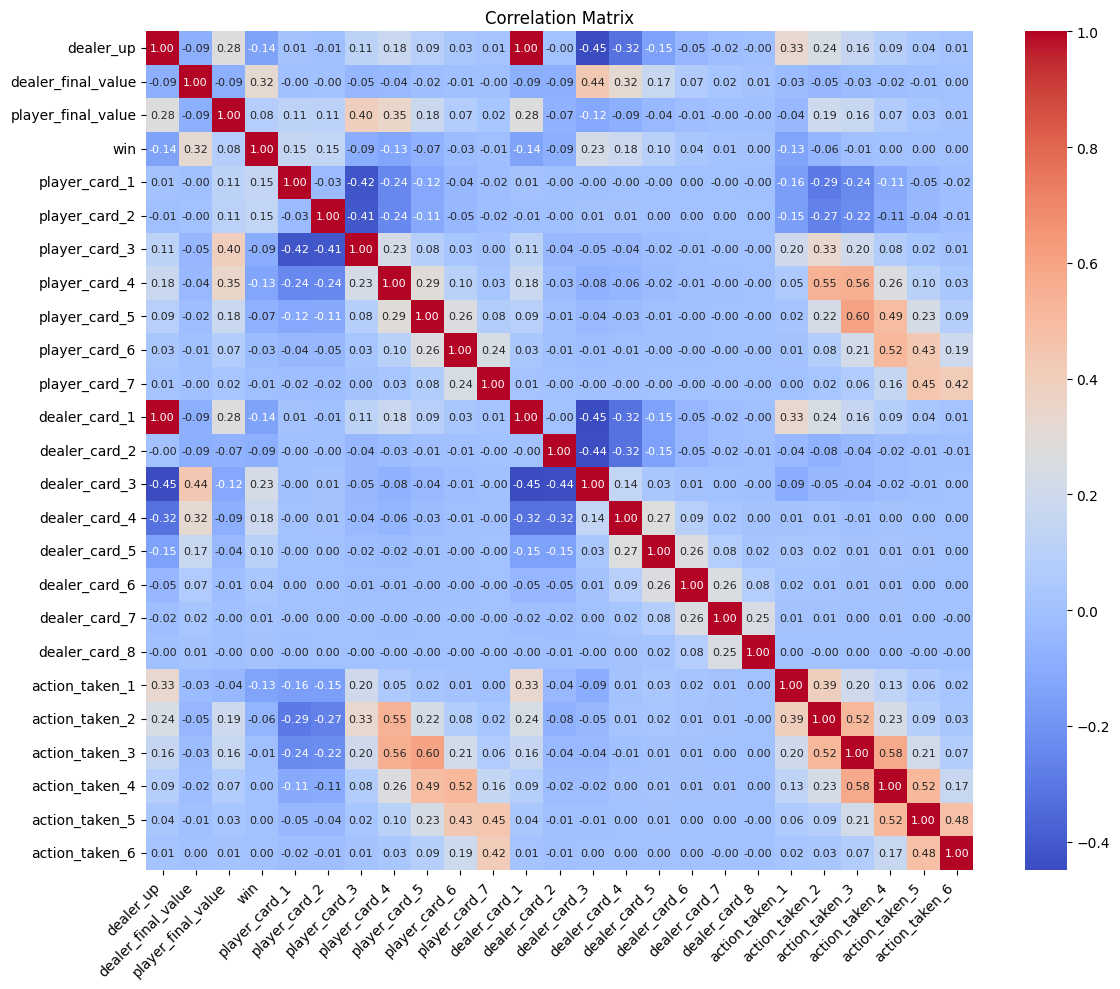

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = data.drop(['shoe_id', 'run_count', 'true_count', 'cards_remaining', 'initial_hand','dealer_final','player_final','actions_taken', 'is_blackjack_dealer', 'is_blackjack_player'], axis=1)
numeric_data = numeric_data.fillna(0)

corr = numeric_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})

# Adjusting ticks to show all labels
plt.xticks(np.arange(len(corr.columns)) + 0.5, corr.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(corr.columns)) + 0.5, corr.columns)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()